In [1]:
import os
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import sklearn.metrics as metrics
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras import models

In [2]:
%load_ext tensorboard

In [3]:
rm -rf ./untitled_project/

In [4]:
rm -rf ./logs/

In [5]:
!pip install imgaug==0.4.0
!pip install imgo

     |████████████████████████████████| 948 kB 44 kB/s  eta 0:00:01
     |████████████████████████████████| 1.0 MB 13.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [6]:
from imgo import uptools

In [7]:
class_names = ['amethyst_deceiver',
               'bolete',
               'chanterelle',
               'chicken_of_the_woods',
               'death_cap',
               'false_chanterelle',
               'false_morel',
               'fibrecap',
               'field_mushroom',
               'fly_agaric',
               'giant_puffball',
               'grey_oyster',
               'morel',
               'orange_peel',
               'roundhead',
               'saddle',
               'shaggy_inkcap',
               'stinkhorn',
               'waxcap',
               'yellow_stainer']


In [8]:
%%time
ds = uptools.Image_Dataset("/floyd/input/ds_1", "h5", 256, normalize=True, manual_classes=class_names)

Processing X_test: 100%|██████████| 1300/1300 [00:00<00:00, 1800.78it/s]


Normalizing...
Image_Datset initialized successfully.
CPU times: user 11.9 s, sys: 6.73 s, total: 18.6 s
Wall time: 38.9 s


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


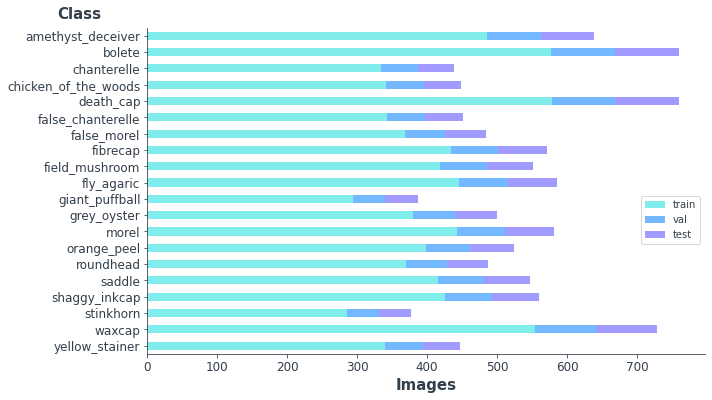

In [9]:
ds.details(plot=True)

In [10]:
def cnn():
    
    inputs = keras.Input(shape=(256,256,3))
    x = layers.Conv2D(64,(3,3),padding='same',kernel_initializer='he_uniform')(inputs)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Conv2D(64,(3,3),padding='same',kernel_initializer='he_uniform')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Conv2D(64,(3,3),padding='same',kernel_initializer='he_uniform')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(128,(3,3),padding='same',kernel_initializer='he_uniform')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Conv2D(128,(3,3),padding='same',kernel_initializer='he_uniform')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(256,(3,3),padding='same',kernel_initializer='he_uniform')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(512,(3,3),padding='same',kernel_initializer='he_uniform')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(512,(3,3),padding='same',kernel_initializer='he_uniform')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1024,kernel_initializer='he_uniform')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Dense(2048,kernel_initializer='he_uniform')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(20)(x)
    outputs = layers.Activation('softmax')(x)   

    opt=optimizers.Nadam(learning_rate=0.00008)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    model.summary()
    
    return model

In [11]:
ne = 15
bs = 32

In [12]:
%%time
ds_net_14 = cnn()
model_path = "ds_net_14.h5"


cp = [ModelCheckpoint(filepath=model_path,
                      monitor="val_accuracy",
                      verbose=1,
                      save_best_only=True)]

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tc = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]

history = ds_net_14.fit(ds.X_train,
                        ds.y_train,
                        validation_data=(ds.X_val,ds.y_val),
                        epochs=ne,
                        batch_size=bs,
                        callbacks=[cp,tc])

with open(f"ds_net_14_history", "wb") as file_pi:
    pickle.dump(history.history, file_pi)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256, 256, 64)     

In [ ]:
model = models.load_model(model_path)
(val_loss, val_acc) = model.evaluate(ds.X_val,ds.y_val,verbose=1)
(test_loss, test_acc) = model.evaluate(ds.X_test,ds.y_test,verbose=1)
print('---')
print(f'Val Loss: {val_loss}')
print(f'Val Accuracy: {val_acc}')
print('---')
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

37/41 [==========================>...] - ETA: 1s - loss: 1.6115 - accuracy: 0.6444

In [ ]:
test_preds = np.argmax(model.predict(ds.X_test,verbose=1),axis=-1)
test_results_df = pd.DataFrame(test_preds,columns=['predicted'])
test_results_df['actual'] = pd.DataFrame(ds.y_test).idxmax(axis=1)
cm = metrics.confusion_matrix(test_results_df['actual'],test_results_df['predicted'])
cmn = np.true_divide(cm, cm.sum(axis=1, keepdims=True))*100
df_cmn = pd.DataFrame(cmn, class_names, class_names)

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(df_cmn, cmap='Blues', cbar=False, annot=True,annot_kws={"size":11}, fmt='.0f', linewidth=0.5)
for t in ax1.texts:
    t.set_text(t.get_text()+'%')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix', fontdict={'fontsize':15})
plt.tight_layout()
plt.savefig("cm.png")
plt.show()